# Sandbox

### Just a simple notebook that can be used to try out some ideas/simulations

In [2]:
import numpy as np
import helper_fcns as hfunc
import model_responses as mod_resp
from scipy.stats.mstats import gmean
import autoreload
import matplotlib.pyplot as plt
#plt.style.use('paul_plt_style.mplstyle')
import matplotlib.backends.backend_pdf as pltSave
import seaborn as sns
%matplotlib inline

# save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures'; # local
# data_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # local

save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/Figures'; # local
data_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/structures/'; # local

# save_loc = '/users/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures/'; # CNS
# data_loc = '/users/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # CNS
expName = 'dataList.npy';
fitName = 'fitList_180426_slowLR.npy';
# fitName = 'fitList_180430_LR_sqrt.npy';
descrName = 'descrFits.npy';
descrModName = 'descrFitsModel.npy';
respName = 'respAboveBase.npy';

# ADJUST
whichCell = 4;

# FIXED
muLoc = 0; # mu is in location '0' of parameter arrays
dOrdLoc = 1;

In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
rcParams['font.size'] = 25
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

Load data, model fits

In [11]:
dataList = np.load(data_loc + expName, encoding='latin1').item();
cellStruct = np.load(data_loc + dataList['unitName'][whichCell-1] + '_sfm.npy', encoding='latin1').item()
modParams = np.load(data_loc + fitName, encoding='latin1').item();
currParams = modParams[whichCell-1]['params']

### Test normalization tuning

In [4]:
autoreload.reload(hfunc);

First, just recapitulating the calculations that determine the SF filters, i.e. hfunc.getInhSfTuning() just redone here

In [4]:
omega = np.logspace(-2, 2, 1000); # frequencies to test

In [5]:
# Compute suppressive SF tuning                                                                                                                                                                                                                                           
# The exponents of the filters used to approximately tile the spatial frequency domain                                                                                                                                                                                    
n = np.array([.75, 1.5]);
# The number of cells in the broad/narrow pool                                                                                                                                                                                                                            
nUnits = np.array([12, 15]);
# The gain of the linear filters in the broad/narrow pool                                                                                                                                                                                                                 
gain = np.array([.57, .614]);

normPool = {'n': n, 'nUnits': nUnits, 'gain': gain};
# Get filter properties in spatial frequency domain                                                                                                                                                                                                                       
gain = np.empty((len(normPool.get('n'))));
for iB in range(len(normPool.get('n'))):
    prefSf_new = np.logspace(np.log10(.1), np.log10(30), normPool.get('nUnits')[iB]);
    if iB == 0:
        prefSf = prefSf_new;
    else:
        prefSf = [prefSf, prefSf_new];
    gain[iB]   = normPool.get('gain')[iB];

In [6]:
for iB in range(len(normPool.get('n'))):
    sfRel = np.matlib.repmat(omega, len(prefSf[iB]), 1).transpose() / prefSf[iB]
    s     = np.power(np.matlib.repmat(omega, len(prefSf[iB]), 1).transpose(), normPool['n'][iB]) \
                * np.exp(-normPool['n'][iB]/2 * np.square(sfRel));
    sMax  = np.power(prefSf[iB], normPool['n'][iB]) * np.exp(-normPool['n'][iB]/2);
    if iB == 0:
        selSf = gain[iB] * s / sMax;
    else:
        selSf = [selSf, gain[iB] * s/sMax];

Plot some filters

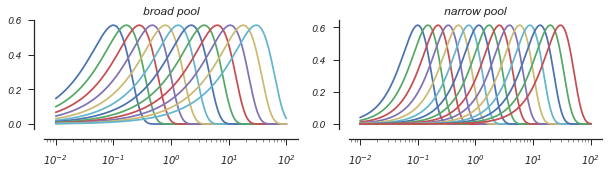

In [7]:
sns.set_style('ticks')
pool_name = ['broad', 'narrow']
f, ax = plt.subplots(1, 2, figsize=(10, 2))
for i in range(2):
    for j in range(selSf[i].shape[1]):
        ax[i].semilogx(omega, selSf[i][:, j])
        ax[i].set_title('%s pool' % pool_name[i])
#     a=plt.semilogx(omega, selSf[0][:, 6])[0];
#     b=plt.semilogx(omega, selSf[1][:, 3])[0];
#     c=plt.semilogx(omega, selSf[1][:, 13])[0];
#     plt.legend([a, b, c], ['broad filter', 'narrow low', 'narrow high']);
sns.despine(offset=10)

# now save
pdf = pltSave.PdfPages(str(save_loc + 'normPool.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

#### What is the (octave) bandwidth of each filter?

In [8]:
height = 1/2.; # e.g. BW at half-height 
nPools = len(normPool['n'])
bw_oct = [];
for iB in range(nPools):
    nFilts = selSf[iB].shape[1];
    bw_oct.append(np.zeros((nFilts, 1)));
    for filt in range(selSf[iB].shape[1]):
        currFilt = selSf[iB][:, filt];
#         currFilt = np.square(selSf[iB][:, filt]);
        maxResp = np.max(currFilt);
        maxInd = np.argmax(currFilt);
        bw_ends = [np.argmin(np.square((maxResp*height - currFilt[0:maxInd]))), 
                   maxInd + np.argmin(np.square((maxResp*height - currFilt[maxInd:])))]
        bw_lin = omega[bw_ends];
        bw_oct[iB][filt] = hfunc.bw_lin_to_log(bw_lin[0], bw_lin[1])

In [9]:
print('Octave bandwidth of broad pool: %s' %(str((np.unique(np.round(bw_oct[0], 2))))));
print('Octave bandwidth of narrow pool: %s' %(str((np.unique(np.round(bw_oct[1], 2))))));

Octave bandwidth of broad pool: [ 3.06  3.07]
Octave bandwidth of narrow pool: [ 2.06  2.07]


#### Compute the normalization tuning given the filters from above

In [12]:
normPool = cellStruct['sfm']['mod']['normalization']
normPref = normPool['pref']['sf'];
normResp = normPool['normResp'];
inhSfTuning = hfunc.getSuppressiveSFtuning(); # 1000 x 27...

Get model optimized weighting/tuning, plot

In [48]:
gs_mean = currParams[-2];
gs_std = 10;
# gs_std = currParams[-1];
nInhChan = 2;
nTrials = inhSfTuning.shape[0];
normWeights = hfunc.genNormWeights(cellStruct, nInhChan, gs_mean, gs_std, 1000)
normWeights = normWeights[:, :, 0]; # each 3rd dim slice is the same, just take one

sfNormCurr = np.sum(.5*(normWeights*np.square(inhSfTuning)), 1);
sfNormTune = sfNormCurr/np.amax(np.abs(sfNormCurr));

In [49]:
sfNormCurr = np.sum(.5*(normWeights*np.square(inhSfTuning)), 1);
sfNormTune = sfNormCurr/np.amax(np.abs(sfNormCurr));

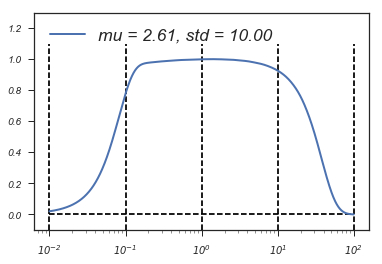

In [58]:
omega = np.logspace(-2, 2, 1000);
plt.semilogx([omega[0], omega[-1]], [0, 0], 'k--')
plt.semilogx([.01, .01], [-0.1, 1.1], 'k--')
plt.semilogx([.1, .1], [-0.1, 1.1], 'k--')
plt.semilogx([1, 1], [-0.1, 1.1], 'k--')
plt.semilogx([10, 10], [-0.1, 1.1], 'k--')
plt.semilogx([100, 100], [-0.1, 1.1], 'k--')
plt.ylim(-0.1, 1.3)

tn = plt.semilogx(omega, sfNormTune, '-', linewidth=2);
plt.legend([tn[0]], ['mu = %.2f, std = %.2f' % (np.exp(gs_mean), gs_std)], loc='upper left', fontsize='x-small');

Now some simulations

In [54]:
nTrials = inhSfTuning.shape[0];
expts = np.multiply([-2, -1, 0, 1, 2], np.divide(2, np.exp(1)));
gs_mean = 0;
nInhChan = normPref; # overwritten in genNormWeights, anyway...
nmWts = [];
for i in expts:
    gs_std = np.exp(i);
    normWeights = hfunc.genNormWeights(cellStruct, nInhChan, gs_mean, gs_std, 1000)
    nmWts.append(normWeights[:, :, 0]); # each 3rd dim slice is the same, just take one

In [56]:
sfNorm = [];
for i in nmWts:
    sfNormCurr = np.sum(.5*(i*np.square(inhSfTuning)), 1);
    sfNorm.append(sfNormCurr/np.amax(np.abs(sfNormCurr)));

Now plot

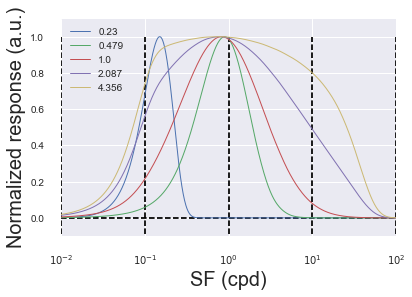

In [57]:
omega = np.logspace(-2, 2, 1000);
plt.semilogx([omega[0], omega[-1]], [0, 0], 'k--')
plt.semilogx([.01, .01], [-1.5, 1], 'k--')
plt.semilogx([.1, .1], [-1.5, 1], 'k--')
plt.semilogx([1, 1], [-1.5, 1], 'k--')
plt.semilogx([10, 10], [-1.5, 1], 'k--')
plt.semilogx([100, 100], [-1.5, 1], 'k--')
# now the real stuff
lines = [];
for i in sfNorm:
    lines.append(plt.semilogx(omega, i, '-', linewidth=1)[0]);
plt.xlim([omega[0], omega[-1]]);
plt.ylim([-0.1, 1.1]);
plt.xlabel('SF (cpd)', fontsize=20);
plt.ylabel('Normalized response (a.u.)', fontsize=20);
plt.legend(lines, [str(np.round(np.exp(x), 3)) for x in expts])
# Remove top/right axis, put ticks only on bottom/left                                                                                                                                                                                                                        
sns.despine(offset=10, trim=False);

### Now, let's test and compare the excitatory filter

In [58]:
omega = np.logspace(-2, 2, 1000);
prefSf = currParams[muLoc];
dOrder = currParams[dOrdLoc];

Compute excitatory filter

In [59]:
sfRel = omega/prefSf;
s     = np.power(omega, dOrder) * np.exp(-dOrder/2 * np.square(sfRel));
sMax  = np.power(prefSf, dOrder) * np.exp(-dOrder/2);
sfExc = s/sMax;

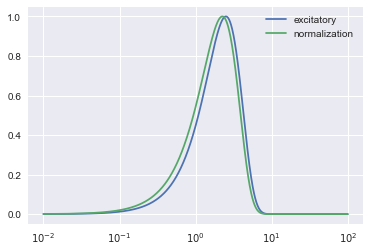

In [60]:
excPlt = plt.semilogx(omega, sfExc);
nrmPlt = plt.semilogx(omega, sfNormTune);
plt.legend([excPlt[0], nrmPlt[0]], ['excitatory', 'normalization']);

Excitatory filter bandwidth?

In [90]:
height = 1/2.;
filts = [sfExc, sfNormTune];
strs = ['Excitatory', 'Normalization']

for i in range(len(filts)):
    filt_i = filts[i];
    maxResp = np.max(filt_i);
    maxInd = np.argmax(filt_i);
    bw_ends = [np.argmin(np.square((maxResp*height - filt_i[0:maxInd]))), 
           maxInd + np.argmin(np.square((maxResp*height - filt_i[maxInd:])))]
    bw_lin = omega[bw_ends];
    bw_oct = hfunc.bw_lin_to_log(bw_lin[0], bw_lin[1])
    print('%s bandwidth (octaves): %.3f' % (strs[i], bw_oct))


Excitatory bandwidth (octaves): 1.969
Normalization bandwidth (octaves): 1.423


## Trying an alternative normalization

Rather than building in a tuned normalization by weighting a fixed bank of filters, we can try a host of other alternatives. One option, which is "wrong" because it creates a variable out of a constant term, is to build a filter which sets the semi-saturation constrast with (center) spatial frequency of the stimulus. Nonetheless, implementing this option will be informative as to the possible range of behaviors possible with a tuned normalization. Two more reasonable options include building a filter bank which better represents known properties of V1 neurons (e.g. distribution and correlation of peak frequency and tuning bandwidth); and an additional exercise of creating just one filter (rather than weighting over many filters) which is more flexible (e.g. two-halved Gaussian)

### Creating an adjustable semi-saturation contrast

In [189]:
autoreload.reload(hfunc);

Some simple plotting of derivative gaussians

In [88]:
dOrds = [1/8., 1/4., 1, 4];
prefSf= 1;

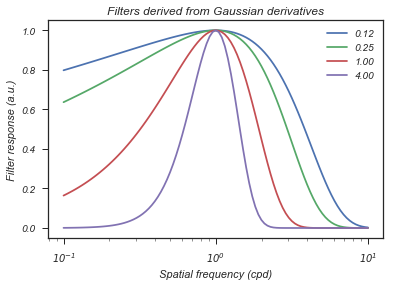

In [103]:
tuning = [];
lines = [];
for d in dOrds:
    tng, stimSf = hfunc.deriv_gauss(prefSf, d);
    tuning.append(tng);
    lines.append(plt.semilogx(stimSf, tng)[0])

plt.title('Filters derived from Gaussian derivatives')
plt.xlabel('Spatial frequency (cpd)');
plt.ylabel('Filter response (a.u.)')
dOrdStr = ['%.2f' % (x) for x in dOrds];
plt.legend(lines, dOrdStr);

Now, our observation from data is that the c50 (semisaturation constant) is lowest near the peak frequency and increases away from the peak. There is an asymmetry, where the semisaturation contrast decreases more towards higher frequencies than towards lower frequencies. Thus, a lower derivative order should give us this shape (see above). Now, we'll need to invert the curve, rescale, and set a baseline (i.e. what is the semisaturation contrast at peak sensitivity). We can also consider the "flexible Gaussian" function.

In [4]:
offset = 0.05;
scale = -(1-offset); # we restrict the c50 between [offset, 1]

# for derivative order
dOrd = 0.15;
prefSf = 4;

# for flexible Gauss - for consistency, we'll set respFloor = 0, respRelFloor = 1 so that offset/scale can be used
respFloor       = 0;
respRelFloor    = 1;
sfPref          = 4;
sigmaLow        = 5;
sigmaHigh       = 1;

In [5]:
c50_filt = lambda eval: scale*hfunc.flexible_Gauss([respFloor, respRelFloor, sfPref, sigmaLow, sigmaHigh], eval, 0) + offset - scale

In [6]:
stimSf = np.logspace(-2, 2, 101);
tngDeriv, _ = hfunc.deriv_gauss([prefSf, dOrd], stimSf);
tngFlex = hfunc.flexible_Gauss([respFloor, respRelFloor, sfPref, sigmaLow, sigmaHigh], stimSf, 0)
tngFlex = np.array(tngFlex)

c50_filter = lambda scale, offset, tuning: scale*tuning + offset - scale

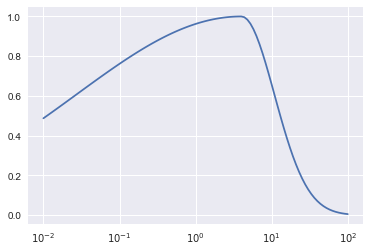

In [7]:
plt.semilogx(stimSf, tngFlex);

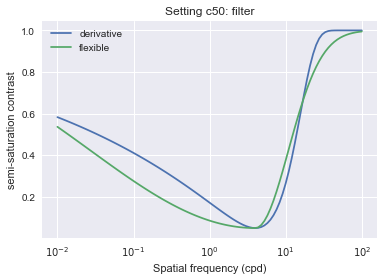

In [8]:
dOrdGauss = plt.semilogx(stimSf, c50_filter(scale, offset, tngDeriv))[0];
flexGauss = plt.semilogx(stimSf, c50_filter(scale, offset, tngFlex))[0];

plt.title('Setting c50: filter')
plt.xlabel('Spatial frequency (cpd)');
plt.ylabel('semi-saturation contrast');
plt.legend([dOrdGauss, flexGauss], ['derivative', 'flexible']);

In [306]:
autoreload.reload(mod_resp);
autoreload.reload(hfunc);

In [351]:
filterFG = dict();
sigmaLow = 0.5;
sigmaHigh = 50;
filterFG['type'] = 1; # flexible gaussian
sfp = 1; # sf pref
filterFG['params'] = [0, 1, sfp, sigmaLow, sigmaHigh]; # 0 for baseline, 1 for respAmpAbvBaseline      
ya = hfunc.evalSigmaFilter(filterFG, -0.95, 0.05, stimSf)

filterDG = dict();
filterDG['type'] = 2; # deriv Gaussian                                                                                                                                                                                                                                   
filterDG['params'] = [sfPref, dOrd];
yaya = hfunc.evalSigmaFilter(filterDG, -0.95, 0.05, stimSf);

In [352]:
offset = 0.05;
scale = -(1-offset);
evalSfs = np.logspace(-2, 2, 101);
# evalSfs = cellStruct['sfm']['exp']['trial']['sf'][0];
zztop = hfunc.evalSigmaFilter(filterFG, scale, offset, np.unique(evalSfs))

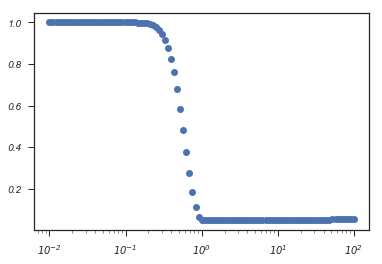

In [353]:
plt.semilogx(np.unique(evalSfs), zztop, 'o');